The corresponding analysis can be found here in this [Notion](https://www.notion.so/eleutherai/Evaluate-NL-Code-Classifier-7742b4b768d54131afc07b06f0610148) page.

In [94]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, precision_recall_curve, PrecisionRecallDisplay, RocCurveDisplay, auc, roc_curve
from IPython.display import display

sns.set()
tqdm.pandas()

%matplotlib inline

## Model Loading

In [95]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AutoModelForSequenceClassification.from_pretrained('usvsnsp/code-vs-nl').to(device)
tokenizer = AutoTokenizer.from_pretrained('usvsnsp/code-vs-nl')

## Data Loading

In [96]:
files = ['data/kyle_eval_set.tsv', 'data/alvin_eval_set.tsv']
all_dfs = [pd.read_csv(f, sep='\t', skiprows=[0, 1]) for f in files]
combined_df = pd.concat(all_dfs)
combined_df.columns = ['label', 'index', 'text']

In [97]:
combined_df.shape

(500, 3)

In [98]:
# seems to be parsing the text fine with tab-separated files
combined_df.dtypes

label    float64
index      int64
text      object
dtype: object

In [99]:
# filter un-labelled samples
evaluation_df = combined_df[~pd.isna(combined_df.label)]
evaluation_df = evaluation_df.astype({'label': np.int64})

## Extracting Scores

In [100]:
evaluation_df.groupby('label').agg({'index': 'nunique'})

,index
label,
0,291
1,199


After filtering some edge cases, we have about 490 samples remaining and 40% of them are classified as code.

In [101]:
@torch.inference_mode()
def get_code_score(text):
    tokens = tokenizer.encode(text, return_tensors='pt', max_length=512, truncation=True).to(device)
    logits = model(tokens).logits
    # natural language = 0, code = 1
    scores = torch.softmax(logits, dim=1)[0]
    nl_score, code_score = (float(s) for s in scores)
    return nl_score, code_score

In [102]:
evaluation_df['nl_score'], evaluation_df['code_score'] = zip(*evaluation_df['text'].progress_apply(get_code_score))
# Specify the ground truth columns
evaluation_df['is_code'] = evaluation_df['label']
evaluation_df['is_natural_language'] = 1 - evaluation_df['label']
evaluation_df.drop('label', axis=1, inplace=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 490/490 [00:03<00:00, 138.76it/s]


In [103]:
evaluation_df.head()

,index,text,nl_score,code_score,is_code,is_natural_language
0,145462125,: 0px } #panel { position:...,0.426246,0.573754,1,0
1,61882691,for reconsideration and construed the debtor'...,0.536427,0.463573,0,1
2,132145011,"imaging systems. Typically, in CT imaging sys...",0.494758,0.505242,0,1
3,9165315,prelude.minimumBy = List.minimumBy; prelude.s...,0.409904,0.590096,1,0
4,115095119,www.icap.com. It’s easy to fall into a patte...,0.505119,0.494881,0,1


In [117]:
import seaborn as sns
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_color_codes("colorblind")
sns.set_theme(style="white")
sns.set_context("talk")
sns.color_palette()
def plot_precision_threshold_curves():
    nl_precision, nl_recall, nl_thresholds = precision_recall_curve(evaluation_df['is_natural_language'], evaluation_df['nl_score'])
    nl_precision = nl_precision[:-1]
    nl_recall = nl_recall[1:]
    df = pd.DataFrame({
        'False Positive Rate':1 - nl_precision,
        'Model Threshold': nl_thresholds
    })
    ax = sns.lineplot(df, x='Model Threshold', y='False Positive Rate', label="Natural Language")
    nl_color = ax.lines[-1].get_color()

    code_precision, code_recall, code_thresholds = precision_recall_curve(evaluation_df['is_code'], evaluation_df['code_score'])
    code_precision = code_precision[:-1]
    code_recall =code_recall[1:]
    code_thresholds = 1 - code_thresholds
    df = pd.DataFrame({
        'False Positive Rate': 1 - code_precision,
        'Model Threshold': code_thresholds
    })
    ax = sns.lineplot(df, x='Model Threshold', y='False Positive Rate', label="Code")
    code_color = ax.lines[-1].get_color()
    
    plt.scatter(x=[0.525], y=[0], marker='o', color=nl_color)
    plt.scatter(x=[0.4], y=[0], marker='o', color=code_color)
    plt.legend()
    sns.move_legend(ax, "lower center", bbox_to_anchor=(0.45, -0.35), ncols=2, frameon=False, title=None)
    plt.savefig("model_thresholding_curves.png", bbox_inches="tight")
    
    plt.show()
    

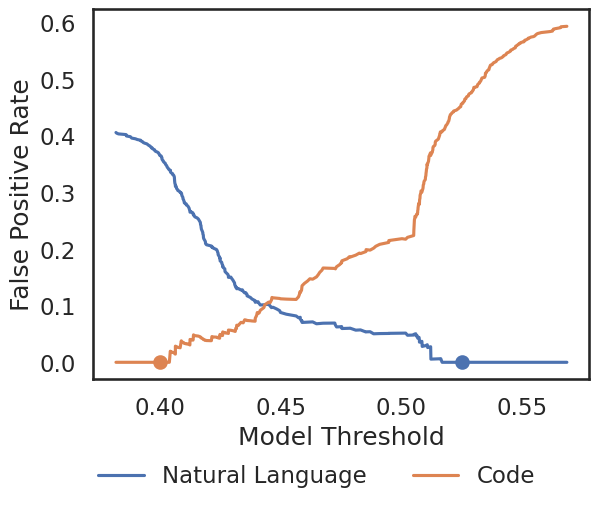

In [118]:
plot_precision_threshold_curves()

## Analysis

Text(0.5, 1.0, '$Score_{NL}$ Distribution')

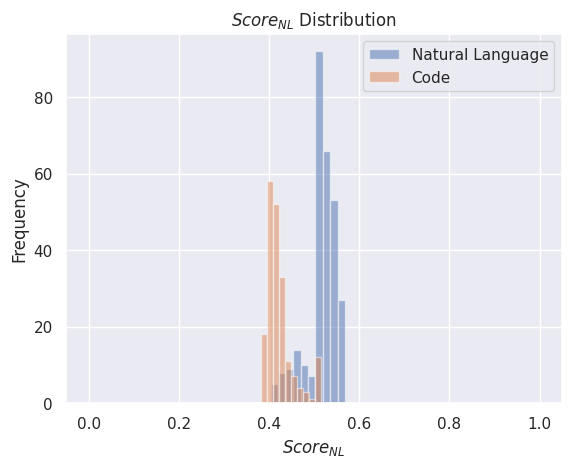

In [12]:
evaluation_df[evaluation_df.is_natural_language == 1].nl_score.hist(bins=10, label='Natural Language', alpha=0.5)
evaluation_df[evaluation_df.is_code == 1].nl_score.hist(bins=10, label='Code', alpha=0.5)
plt.xlim(-0.05, 1.05)
plt.ylabel('Frequency')
plt.xlabel('$Score_{NL}$')
plt.legend()
plt.title('$Score_{NL}$ Distribution')

In [13]:
def plot_pr_roc_curves(labels, preds):
    precision, recall, pr_thresholds = precision_recall_curve(labels, preds)
    pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
    pr_auc = auc(recall, precision)

    fpr, tpr, roc_thresholds = roc_curve(labels, preds)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
    roc_auc = auc(fpr, tpr)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.set_title(rf'$AUC_{{roc}}$ = {roc_auc:.4f}')
    ax2.set_title(rf'$AUC_{{pr}}$ = {pr_auc:.4f}')
    roc_display.plot(ax=ax1)
    pr_display.plot(ax=ax2)
    
    return precision, recall, pr_thresholds

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


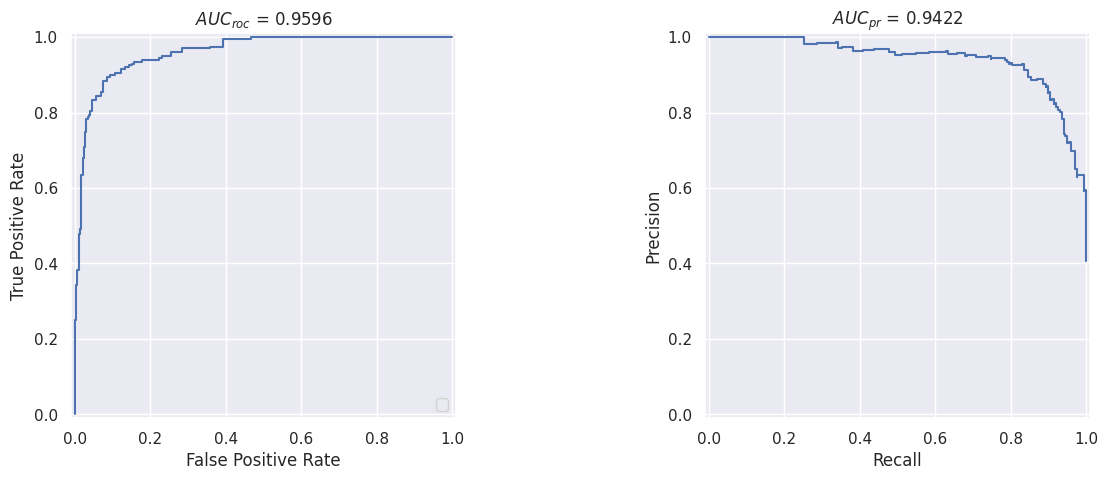

In [14]:
# Performance on code classification
code_precision, code_recall, code_thresholds = plot_pr_roc_curves(evaluation_df.is_code, evaluation_df.code_score)

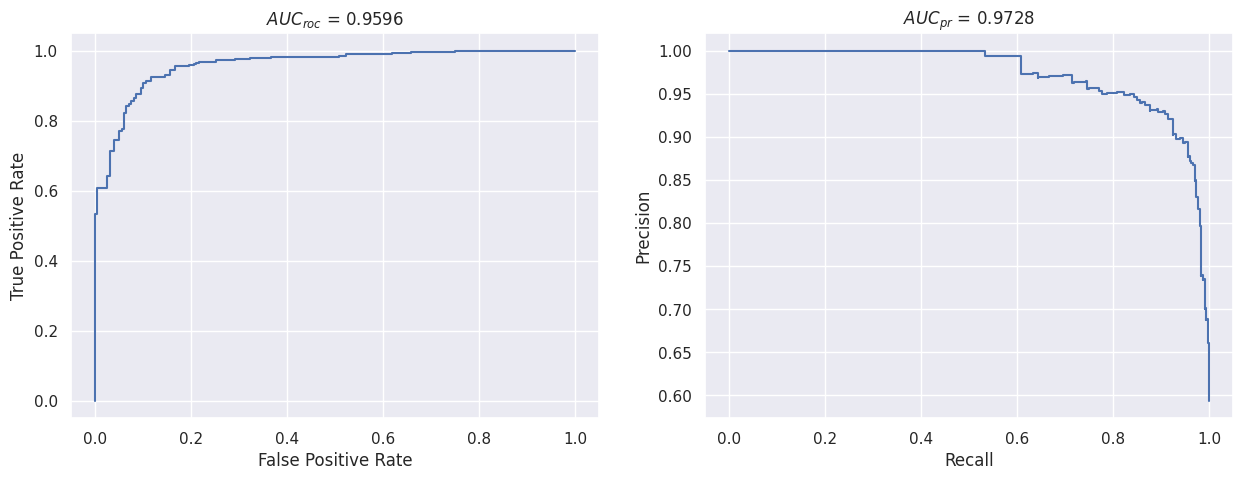

In [12]:
# Performance on natural language classification
nl_precision, nl_recall, nl_thresholds = plot_pr_roc_curves(evaluation_df.is_natural_language, evaluation_df.nl_score)

The model performance looks pretty good as a code/natural langauge classifier, although the sample size is small. In this analysis, we're interested in the performance of the model classifying natural languages.

In [105]:
nl_threshold_df = pd.DataFrame(
    np.hstack((nl_precision[:-1][:, np.newaxis], nl_recall[:-1][:, np.newaxis], nl_thresholds[:, np.newaxis])),
    columns=['precision', 'recall', 'threshold']
)
nl_threshold_df['f1_score'] = 2 * (nl_threshold_df.precision * nl_threshold_df.recall) / (nl_threshold_df.precision + nl_threshold_df.recall)

In [110]:
nl_threshold_df.sort_values('f1_score', ascending=False).head(10)

,precision,recall,threshold,f1_score
177,0.893891,0.955326,0.439542,0.923588
196,0.921233,0.924399,0.457414,0.922813
176,0.891026,0.955326,0.439489,0.922056
178,0.893548,0.951890,0.440109,0.921797
182,0.898693,0.945017,0.441622,0.921273
195,0.918089,0.924399,0.456445,0.921233
197,0.920962,0.920962,0.457808,0.920962
175,0.888179,0.955326,0.438214,0.920530
201,0.926829,0.914089,0.458684,0.920415
179,0.893204,0.948454,0.440379,0.920000


After evaluating various thresholds, the threshold of 0.95 seems reasonable given we're still able to maintain 82% recall.

## Error Analysis

In [111]:
model_threshold = 0.457414
evaluation_df['prec_95_nl_prediction'] = evaluation_df.progress_apply(lambda x: int(x.nl_score >= model_threshold), axis=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 490/490 [00:00<00:00, 35468.88it/s]


In [112]:
# False Positive
fp_df = evaluation_df[
    (evaluation_df.prec_95_nl_prediction == 1) & (evaluation_df.is_natural_language == 0)
]
# False negative
fn_df = evaluation_df[
    (evaluation_df.prec_95_nl_prediction == 0) & (evaluation_df.is_natural_language == 1)
]

In [113]:
fp_df.shape, fn_df.shape

((23, 7), (22, 7))

In [114]:
for i, (_, row) in enumerate(fp_df.sort_values('nl_score', ascending=False).iterrows()):
    print(f'> Example {i + 1}')
    print(f'> code_score: {row.code_score:.4f}')
    print(f'> nl_score: {row.nl_score:.4f}')
    print(f'> text: {row.text}')
    print()

> Example 1
> code_score: 0.4838
> nl_score: 0.5162
> text:  132, 41, 132, 41, 132, 41, 132, 41, 132, 41, 132, 41, 132, 41, 132, 41, 132, 41, 132, 41, 132, 41, 132, 41, 132, 41, 132, 41, 132, 41, 132, 41,

> Example 2
> code_score: 0.4879
> nl_score: 0.5121
> text: MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM

> Example 3
> code_score: 0.4879
> nl_score: 0.5121
> text: ACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKK

> Example 4
> code_score: 0.4879
> nl_score: 0.5121
> text: 096687AM096688AM096689AM096690AM096691AM096692AM096693AM096694AM096695AM096696AM096697AM096698AM096699AM096700AM096701AM096702AM096703AM096704AM096705AM

> Example 5
> code_score: 0.4879
> nl_score: 0.5121
> text: 15604407723907138105158593079608667017242712188399879790879227492190169972088809377665727333001053367881220235421809751254540594752243525849

In [116]:
for i, (_, row) in enumerate(fn_df.sort_values('nl_score', ascending=False).iterrows()):
    print(f'> Example {i + 1}')
    print(f'> code_score: {row.code_score:.4f}')
    print(f'> nl_score: {row.nl_score:.4f}')
    print(f'> text: {row.text}')
    print()

> Example 1
> code_score: 0.5536
> nl_score: 0.4464
> text:  #     https://www.apache.org/licenses/LICENSE-2.0 # # Unless required by applicable law or agreed to in writing, software # distributed under the License is distributed on an "AS IS" BASIS, # WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied

> Example 2
> code_score: 0.5538
> nl_score: 0.4462
> text:  to the Apache Software Foundation (ASF) under one or more  * contributor license agreements.  See the NOTICE file distributed with  * this work for additional information regarding copyright ownership.  * The ASF licenses this file to You under the Apache License, Version 2.0  * (the "License"); you

> Example 3
> code_score: 0.5549
> nl_score: 0.4451
> text:                              Simon Castellan  <simon.castellan(_)iuwt.fr>    Permission is hereby granted, free of charge, to any person obtaining a   copy of this software and associated documentation files (the "Software"),   to deal in the Software

In [129]:
for i, (_, row) in enumerate(combined_df[pd.isna(combined_df.label)].iterrows()):
    if not pd.isna(row.text):
        nl_score, code_score = get_code_score(row.text)
        print(f'> Example {i + 1}')
        print(f'> code_score: {code_score:.4f}')
        print(f'> nl_score: {nl_score:.4f}')
        print(f'> text: {row.text}')
        print()

> Example 1
> code_score: 0.4835
> nl_score: 0.5165
> text:                                                                          The Supreme Court of Nevada        Appellate Case Management System     C-Track, the browser based CMS for Appellate Courts                             

> Example 2
> code_score: 0.6106
> nl_score: 0.3894
> text: OptionLvlThree'><a href="#"> More option </a>             </li>             <li class='listOptionLvlThree'><a href="#"> More option </a>             </li>             <li class='listOptionLvlThree'><a href="#"> More option </

> Example 3
> code_score: 0.5884
> nl_score: 0.4116
> text: </folder> <filename>0--Parade_0_Parade_Parade_0_167.jpg</filename> <source> <database>wider face Database</database> <annotation>PASCAL VOC2007</annotation> <image>flickr</image

> Example 4
> code_score: 0.6022
> nl_score: 0.3978
> text:   /* On mouse-over, add a grey background color */ .container:hover input ~.checkmark {   background-color: #ccc; }  /* When th